In [1]:
# Librerías básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis 
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>. 

In [2]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 

# Fuentes de datos interesantes

## API de Yahoo finance

Yahoo Finance tiene una API que permite descargar información financiera para realizar análisis. La página web original de la documentación ya no existe. Sin embargo, existen algunas páginas de documentación no oficial como <a href= 'https://github.com/mxbi/yahoo-finance-api.git'> este repositorio en GitHub, </a> o <a href='https://python-yahoofinance.readthedocs.io/en/latest/api.html'> esta página de documentación the ReadTheDocs </a>.

In [3]:
# Instalación de yfinance
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Se importa la librería yfinance
import yfinance

In [5]:
# Se descargan los datos S&P500 y Nikkei225
df_yfinance_raw = yfinance.download(tickers = "^GSPC ^N225", #Las series de tiempo de interés - (en nuestro caso, S&P500 y NIKKEI225)
                              start = "1994-01-07", #Fecha inicial
                              end = "2024-08-27", #Fecha final
                              interval = "1d", #Frecuencia.
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,  
                              #threads = True
                               ) #. 

[*********************100%***********************]  2 of 2 completed


In [6]:
df_yfinance_raw.head()

Ticker                          ^GSPC                                      \
Price                            Open        High         Low       Close   
Date                                                                        
1994-01-07 00:00:00+00:00  467.089996  470.260010  467.029999  469.899994   
1994-01-10 00:00:00+00:00  469.899994  475.269989  469.549988  475.269989   
1994-01-11 00:00:00+00:00  475.269989  475.279999  473.269989  474.130005   
1994-01-12 00:00:00+00:00  474.130005  475.059998  472.140015  474.170013   
1994-01-13 00:00:00+00:00  474.170013  474.170013  471.799988  472.470001   

Ticker                                         ^N225                \
Price                           Volume          Open          High   
Date                                                                 
1994-01-07 00:00:00+00:00  324920000.0  17842.980469  18131.410156   
1994-01-10 00:00:00+00:00  319490000.0  18186.519531  18567.060547   
1994-01-11 00:00:00+00:00  305490000.0  18481.849609  18671.669922   
1994-01-12 00:00:00+00:00  310690000.0  18447.339844  18807.080078   
1994-01-13 00:00:00+00:00  277970000.0  18770.380859  18823.380859   

Ticker                                                        
Price                               Low         Close Volume  
Date                                                          
1994-01-07 00:00:00+00:00  17787.480469  18124.009766    0.0  
1994-01-10 00:00:00+00:00  18186.519531  18443.439453    0.0  
1994-01-11 00:00:00+00:00  18373.039062  18485.250000    0.0  
1994-01-12 00:00:00+00:00  18301.929688  18793.880859    0.0  
1994-01-13 00:00:00+00:00  18548.750000  18577.259766    0.0

In [7]:
# Se crea una copia para modificar
df_yfinance = df_yfinance_raw.copy()

In [8]:
# Se agregan columnas para el nivel de cierre de los índices S&P500 y Nikkei255
df_yfinance['spx'] = df_yfinance['^GSPC'].Close
df_yfinance['nikkei'] = df_yfinance['^N225'].Close

In [9]:
#f_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_yfinance['^N225'] # Se retiran los grupos de columnas '^N225' y '^GSPC'
del df_yfinance['^GSPC']
df_yfinance=df_yfinance.asfreq('b') # Se establece la frecuencia de los datos
df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido

In [10]:
df_yfinance.head()

Ticker,spx,nikkei
Price,,
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [11]:
df_yfinance.columns

MultiIndex([(   'spx', ''),
            ('nikkei', '')],
           names=['Ticker', 'Price'])

In [12]:
df_yfinance.columns=['spx','nikkei']

In [13]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [14]:
df_yfinance.head() 

,spx,nikkei
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


In [15]:
df_yfinance.tail() # Making sure of the last day we're including in the series

,spx,nikkei
Date,,
2024-08-20 00:00:00+00:00,5597.120117,38062.921875
2024-08-21 00:00:00+00:00,5620.850098,37951.800781
2024-08-22 00:00:00+00:00,5570.640137,38211.011719
2024-08-23 00:00:00+00:00,5634.609863,38364.269531
2024-08-26 00:00:00+00:00,5616.839844,38110.218750


In [16]:
#df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#df_comp.set_index("date", inplace=True)
df_yfinance=df_yfinance.asfreq('b')
df_yfinance=df_yfinance.fillna(method='ffill')

In [17]:
df_yfinance.head()

,spx,nikkei
Date,,
1994-01-07 00:00:00+00:00,469.899994,18124.009766
1994-01-10 00:00:00+00:00,475.269989,18443.439453
1994-01-11 00:00:00+00:00,474.130005,18485.250000
1994-01-12 00:00:00+00:00,474.170013,18793.880859
1994-01-13 00:00:00+00:00,472.470001,18577.259766


## Algunos archivos csv con datos

En <a href='https://github.com/jbrownlee/Datasets.git'>este repositorio de GitHub</a> se encuentran muchos archivos .csv con datos apropiados para ejercicios de aprendizaje de máquina y series de tiempo. En este notebook utilizaremos el archivo 'airline_passengers.csv'.

In [18]:
df_airline = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [19]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Datos que vienen con la librería statsmodels
La librería <a href='https://www.statsmodels.org/stable/index.html'>statsmodels</a> tiene varios conjuntos de datos incorporados.
En este notebook, utilizaremos el dataset 'macrodata', que trae datos macroeconómicos de EEUU.

In [20]:
#import pandas as pd
import statsmodels.api as sm
df_macrodata = sm.datasets.macrodata.load_pandas().data
df_macrodata.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [21]:
df_macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## Datos de simulados de ventas

In [22]:
df_ventas = pd.read_excel('Datos_clase_1.xlsx',index_col = 'Fecha', parse_dates = True)

# Modelos AR

## Yahoo finance

### Estacionaridad

In [23]:
sts.adfuller(df_yfinance['spx'])

(2.495421902147278,
 0.9990483594146493,
 32,
 7959,
 {'1%': -3.4311718884675066,
  '5%': -2.861903215555782,
  '10%': -2.566963334958385},
 72367.34132821791)

### PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


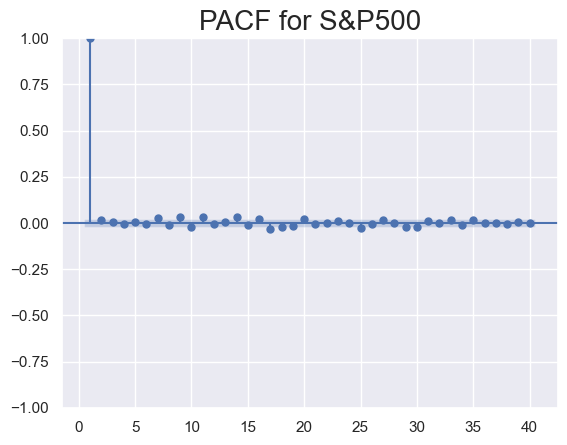

In [24]:
sgt.plot_pacf(df_yfinance['spx'], zero = False, lags = 40)
plt.title("PACF for S&P500", size = 20)
plt.show()

### Modelo AR(1)

In [25]:
yfinance_model_ar_1 = ARIMA(df_yfinance['spx'], order=(1,0,0))

In [26]:
yfinance_results_ar_1 = yfinance_model_ar_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [27]:
yfinance_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -36454.616
Date:                Wed, 18 Sep 2024   AIC                          72915.231
Time:                        17:52:26   BIC                          72936.190
Sample:                    01-07-1994   HQIC                         72922.406
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.9555   1144.491      1.589      0.112    -424.206    4062.117
ar.L1          0.9998      0.000   6308.795      0.000       1.000       1.000
sigma2       535.8763      2.663    201.206      0.000     530.656     541.096
===================================================================================
Ljung-Box (L1) (Q):                  49.71   Jarque-Bera (JB):            117805.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.68   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AR de mayor complejidad

In [28]:
yfinance_model_ar_2 = ARIMA(df_yfinance['spx'], order=(2,0,0))

In [29]:
yfinance_results_ar_2 = yfinance_model_ar_2.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [30]:
yfinance_results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -36429.118
Date:                Wed, 18 Sep 2024   AIC                          72866.236
Time:                        17:52:42   BIC                          72894.181
Sample:                    01-07-1994   HQIC                         72875.802
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8396   5.59e-05   3.25e+07      0.000    1818.839    1818.840
ar.L1          0.9214      0.004    236.593      0.000       0.914       0.929
ar.L2          0.0785      0.004     20.182      0.000       0.071       0.086
sigma2       532.3706      2.799    190.217      0.000     526.885     537.856
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            104978.47
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.59   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.5e+20. Standard errors may be unstable.
"""

In [31]:
yfinance_model_ar_5 = ARIMA(df_yfinance['spx'], order=(5,0,0))

In [32]:
yfinance_results_ar_5 = yfinance_model_ar_5.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
yfinance_results_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(5, 0, 0)   Log Likelihood              -36425.183
Date:                Wed, 18 Sep 2024   AIC                          72864.365
Time:                        17:53:13   BIC                          72913.269
Sample:                    01-07-1994   HQIC                         72881.105
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8236   2.97e-05   6.12e+07      0.000    1818.824    1818.824
ar.L1          0.9235      0.004    217.295      0.000       0.915       0.932
ar.L2          0.0986      0.005     20.458      0.000       0.089       0.108
ar.L3         -0.0409      0.005     -7.953      0.000      -0.051      -0.031
ar.L4          0.0075      0.006      1.352      0.176      -0.003       0.018
ar.L5          0.0112      0.004      2.499      0.012       0.002       0.020
sigma2       532.0073      2.899    183.523      0.000     526.326     537.689
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            104164.45
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               8.58   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+20. Standard errors may be unstable.
"""

### Pruebas LLR

In [34]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF)
    return p

In [35]:
LLR_test(yfinance_model_ar_1, yfinance_model_ar_5)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.6877246082348023e-14

## Vuelos

### Estacionaridad

In [36]:
sts.adfuller(df_airline['Passengers'])

(0.8153688792060441,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

### PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


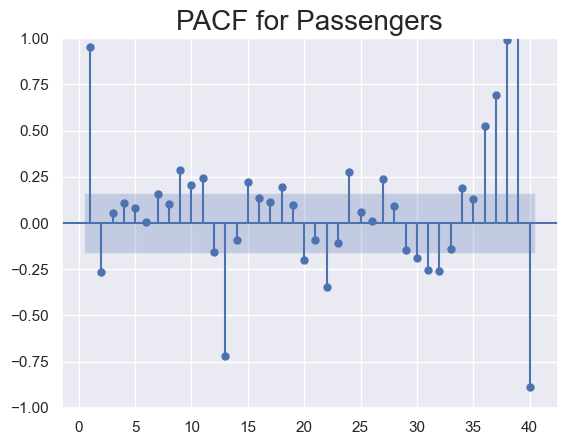

In [37]:
sgt.plot_pacf(df_airline['Passengers'], zero = False, lags = 40)
plt.title("PACF for Passengers", size = 20)
plt.show()

### Modelo AR(1)

In [38]:
airline_model_ar_1 = ARIMA(df_airline['Passengers'], order=(1,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
airline_results_ar_1 = airline_model_ar_1.fit()

In [40]:
airline_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -711.090
Date:                Wed, 18 Sep 2024   AIC                           1428.181
Time:                        17:53:42   BIC                           1437.090
Sample:                    01-01-1949   HQIC                          1431.801
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2943     66.403      4.221      0.000     150.146     410.442
ar.L1          0.9645      0.019     51.535      0.000       0.928       1.001
sigma2      1118.5409    122.133      9.158      0.000     879.164    1357.918
===================================================================================
Ljung-Box (L1) (Q):                  13.91   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.00   Prob(JB):                         0.67
Heteroskedasticity (H):               7.92   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos AR más complejos

In [41]:
airline_model_ar_2 = ARIMA(df_airline['Passengers'], order=(2,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [42]:
airline_results_ar_2 = airline_model_ar_2.fit()

In [43]:
airline_results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -702.819
Date:                Wed, 18 Sep 2024   AIC                           1413.639
Time:                        17:53:42   BIC                           1425.518
Sample:                    01-01-1949   HQIC                          1418.466
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.2991     54.518      5.141      0.000     173.445     387.153
ar.L1          1.2831      0.079     16.316      0.000       1.129       1.437
ar.L2         -0.3322      0.082     -4.054      0.000      -0.493      -0.172
sigma2       995.9158    110.760      8.992      0.000     778.830    1213.001
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 2.84
Prob(Q):                              0.49   Prob(JB):                         0.24
Heteroskedasticity (H):               6.78   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
airline_model_ar_10 = ARIMA(df_airline['Passengers'], order=(10,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
airline_results_ar_10 = airline_model_ar_10.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
airline_results_ar_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(10, 0, 0)   Log Likelihood                -672.002
Date:                Wed, 18 Sep 2024   AIC                           1368.004
Time:                        17:53:45   BIC                           1403.641
Sample:                    01-01-1949   HQIC                          1382.485
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3051    193.924      1.445      0.148     -99.779     660.390
ar.L1          1.1467      0.106     10.866      0.000       0.940       1.354
ar.L2         -0.4601      0.159     -2.885      0.004      -0.773      -0.148
ar.L3          0.1787      0.144      1.240      0.215      -0.104       0.461
ar.L4         -0.3042      0.116     -2.626      0.009      -0.531      -0.077
ar.L5          0.3776      0.139      2.720      0.007       0.106       0.650
ar.L6         -0.2164      0.156     -1.383      0.167      -0.523       0.090
ar.L7          0.2262      0.123      1.840      0.066      -0.015       0.467
ar.L8         -0.4024      0.153     -2.622      0.009      -0.703      -0.102
ar.L9          0.2697      0.153      1.762      0.078      -0.030       0.570
ar.L10         0.1804      0.086      2.086      0.037       0.011       0.350
sigma2       629.4168     82.153      7.662      0.000     468.400     790.433
===================================================================================
Ljung-Box (L1) (Q):                   4.28   Jarque-Bera (JB):                 8.24
Prob(Q):                              0.04   Prob(JB):                         0.02
Heteroskedasticity (H):               6.32   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas LLR

In [47]:
LLR_test(airline_model_ar_1, airline_model_ar_10,DF=9)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.717295410475622e-13

## Datos de ventas

### Estacionaridad

In [48]:
sts.adfuller(df_ventas['Ventas'])

(-2.853928653615534,
 0.05097376463402474,
 13,
 351,
 {'1%': -3.44911857009962,
  '5%': -2.8698097654570507,
  '10%': -2.5711757061225153},
 6365.4145809406855)

### PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


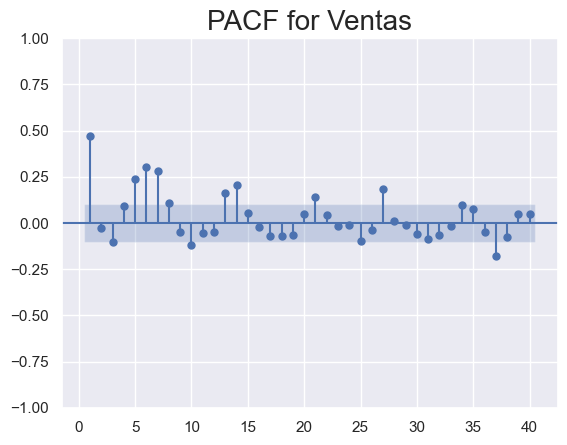

In [49]:
sgt.plot_pacf(df_ventas['Ventas'], zero = False, lags = 40)
plt.title("PACF for Ventas", size = 20)
plt.show()

### Modelo AR(1)

In [50]:
ventas_model_ar_1 = ARIMA(df_ventas['Ventas'], order=(1,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [51]:
ventas_results_ar_1 = ventas_model_ar_1.fit()

In [52]:
ventas_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3401.112
Date:                Wed, 18 Sep 2024   AIC                           6808.224
Time:                        17:53:48   BIC                           6819.923
Sample:                    01-01-2023   HQIC                          6812.873
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    271.223     69.431      0.000    1.83e+04    1.94e+04
ar.L1          0.4780      0.047     10.197      0.000       0.386       0.570
sigma2      7.203e+06   5.11e+05     14.110      0.000     6.2e+06     8.2e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.03
Prob(Q):                              0.83   Prob(JB):                         0.05
Heteroskedasticity (H):               0.95   Skew:                            -0.29
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos AR más complejos

In [53]:
ventas_model_ar_6 = ARIMA(df_ventas['Ventas'], order=(6,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [54]:
ventas_results_ar_6 = ventas_model_ar_6.fit()

In [55]:
ventas_results_ar_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(6, 0, 0)   Log Likelihood               -3369.655
Date:                Wed, 18 Sep 2024   AIC                           6755.309
Time:                        17:53:48   BIC                           6786.508
Sample:                    01-01-2023   HQIC                          6767.708
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    447.008     42.127      0.000     1.8e+04    1.97e+04
ar.L1          0.4062      0.054      7.514      0.000       0.300       0.512
ar.L2          0.0632      0.056      1.126      0.260      -0.047       0.173
ar.L3         -0.1083      0.057     -1.896      0.058      -0.220       0.004
ar.L4         -0.0399      0.050     -0.799      0.424      -0.138       0.058
ar.L5          0.0927      0.058      1.592      0.111      -0.021       0.207
ar.L6          0.3019      0.052      5.796      0.000       0.200       0.404
sigma2      6.114e+06   4.77e+05     12.824      0.000    5.18e+06    7.05e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.78   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.10   Prob(JB):                         0.31
Heteroskedasticity (H):               1.05   Skew:                            -0.20
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
ventas_model_ar_7 = ARIMA(df_ventas['Ventas'], order=(7,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [57]:
ventas_results_ar_7 = ventas_model_ar_7.fit()

In [58]:
ventas_results_ar_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -3355.384
Date:                Wed, 18 Sep 2024   AIC                           6728.767
Time:                        17:53:49   BIC                           6763.866
Sample:                    01-01-2023   HQIC                          6742.716
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    578.798     32.535      0.000    1.77e+04       2e+04
ar.L1          0.3226      0.054      5.975      0.000       0.217       0.428
ar.L2          0.0384      0.054      0.708      0.479      -0.068       0.145
ar.L3         -0.0976      0.056     -1.756      0.079      -0.206       0.011
ar.L4         -0.0089      0.047     -0.189      0.850      -0.102       0.084
ar.L5          0.0760      0.054      1.395      0.163      -0.031       0.183
ar.L6          0.1891      0.056      3.366      0.001       0.079       0.299
ar.L7          0.2759      0.052      5.271      0.000       0.173       0.378
sigma2      5.661e+06   4.19e+05     13.503      0.000    4.84e+06    6.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.47   Prob(JB):                         0.53
Heteroskedasticity (H):               1.02   Skew:                            -0.13
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
ventas_model_ar_8 = ARIMA(df_ventas['Ventas'], order=(8,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [60]:
ventas_results_ar_8 = ventas_model_ar_8.fit()

In [61]:
ventas_results_ar_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(8, 0, 0)   Log Likelihood               -3352.717
Date:                Wed, 18 Sep 2024   AIC                           6725.434
Time:                        17:53:49   BIC                           6764.433
Sample:                    01-01-2023   HQIC                          6740.933
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    641.414     29.359      0.000    1.76e+04    2.01e+04
ar.L1          0.2904      0.054      5.378      0.000       0.185       0.396
ar.L2          0.0146      0.054      0.271      0.787      -0.091       0.120
ar.L3         -0.1061      0.054     -1.948      0.051      -0.213       0.001
ar.L4         -0.0083      0.046     -0.180      0.857      -0.099       0.082
ar.L5          0.0888      0.053      1.661      0.097      -0.016       0.194
ar.L6          0.1854      0.054      3.419      0.001       0.079       0.292
ar.L7          0.2359      0.052      4.508      0.000       0.133       0.338
ar.L8          0.1228      0.053      2.299      0.022       0.018       0.227
sigma2      5.477e+06   3.95e+05     13.859      0.000     4.7e+06    6.25e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.99   Prob(JB):                         0.37
Heteroskedasticity (H):               1.01   Skew:                            -0.16
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas LLR

In [62]:
LLR_test(ventas_model_ar_1, ventas_model_ar_8,DF=7)

4.959256004128716e-18

## Datos macroeconómicos de EEUU: PBI real

### Estacionaridad

In [63]:
sts.adfuller(df_macrodata['realgdp'])

(1.7504627967647133,
 0.9982455372335032,
 12,
 190,
 {'1%': -3.4652439354133255,
  '5%': -2.8768752281673717,
  '10%': -2.574944653739612},
 2034.517123668382)

### PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


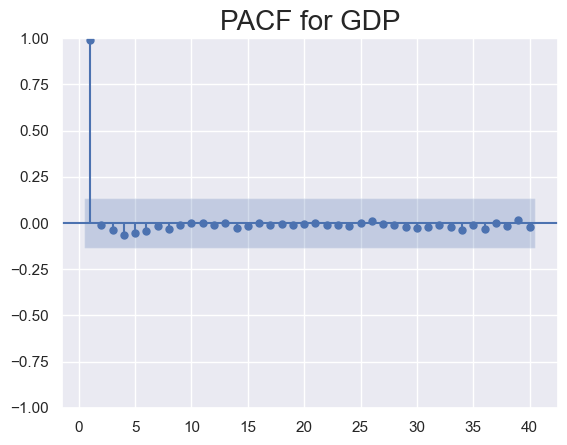

In [64]:
sgt.plot_pacf(df_macrodata['realgdp'], zero = False, lags = 40)
plt.title("PACF for GDP", size = 20)
plt.show()

### Modelo AR(1)

In [65]:
realgdp_model_ar_1 = ARIMA(df_macrodata['realgdp'], order=(1,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [66]:
realgdp_results_ar_1 = realgdp_model_ar_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [67]:
realgdp_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  203
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1178.136
Date:                Wed, 18 Sep 2024   AIC                           2362.272
Time:                        17:53:51   BIC                           2372.212
Sample:                    03-31-1959   HQIC                          2366.293
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7221.2951   8771.072      0.823      0.410   -9969.690    2.44e+04
ar.L1          0.9999      0.002    586.821      0.000       0.997       1.003
sigma2      6173.3228    651.203      9.480      0.000    4896.988    7449.658
===================================================================================
Ljung-Box (L1) (Q):                  33.17   Jarque-Bera (JB):                71.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Datos macroeconómicos de EEUU: Inflación

### Estacionaridad

In [68]:
sts.adfuller(df_macrodata['infl'])

(-3.054514496257236,
 0.03010762086348588,
 2,
 200,
 {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225},
 852.1494477600706)

### PACF

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


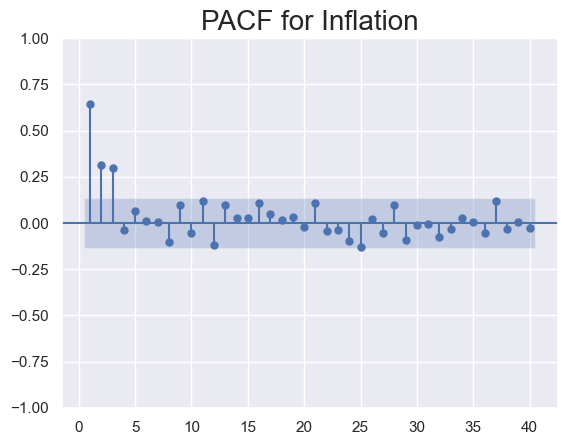

In [69]:
sgt.plot_pacf(df_macrodata['infl'], zero = False, lags = 40)
plt.title("PACF for Inflation", size = 20)
plt.show()

### Modelo AR(1)

In [70]:
inflation_model_ar_1 = ARIMA(df_macrodata['infl'], order=(1,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [71]:
inflation_results_ar_1 = inflation_model_ar_1.fit()

In [72]:
inflation_results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   infl   No. Observations:                  203
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -472.714
Date:                Wed, 18 Sep 2024   AIC                            951.427
Time:                        17:53:51   BIC                            961.367
Sample:                    03-31-1959   HQIC                           955.449
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9230      0.494      7.939      0.000       2.955       4.891
ar.L1          0.6441      0.039     16.482      0.000       0.567       0.721
sigma2         6.1518      0.397     15.488      0.000       5.373       6.930
===================================================================================
Ljung-Box (L1) (Q):                   8.43   Jarque-Bera (JB):                68.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.22
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos AR más complejos

In [73]:
inflation_model_ar_2 = ARIMA(df_macrodata['infl'], order=(2,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [74]:
inflation_results_ar_2 = inflation_model_ar_2.fit()

In [75]:
inflation_results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   infl   No. Observations:                  203
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -462.419
Date:                Wed, 18 Sep 2024   AIC                            932.839
Time:                        17:53:52   BIC                            946.092
Sample:                    03-31-1959   HQIC                           938.200
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8852      0.702      5.535      0.000       2.509       5.261
ar.L1          0.4433      0.038     11.634      0.000       0.369       0.518
ar.L2          0.3102      0.041      7.516      0.000       0.229       0.391
sigma2         5.5531      0.348     15.969      0.000       4.872       6.235
===================================================================================
Ljung-Box (L1) (Q):                   1.75   Jarque-Bera (JB):               129.51
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.64
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
inflation_model_ar_3 = ARIMA(df_macrodata['infl'], order=(3,0,0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [77]:
inflation_results_ar_3 = inflation_model_ar_3.fit()

In [78]:
inflation_results_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   infl   No. Observations:                  203
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -453.556
Date:                Wed, 18 Sep 2024   AIC                            917.112
Time:                        17:53:52   BIC                            933.678
Sample:                    03-31-1959   HQIC                           923.814
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8113      0.945      4.035      0.000       1.960       5.663
ar.L1          0.3522      0.047      7.445      0.000       0.259       0.445
ar.L2          0.1819      0.047      3.833      0.000       0.089       0.275
ar.L3          0.2891      0.064      4.551      0.000       0.165       0.414
sigma2         5.0824      0.302     16.808      0.000       4.490       5.675
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -0.72
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas LLR

In [79]:
LLR_test(inflation_model_ar_1, inflation_model_ar_3,DF=2)

4.786173147380305e-09

# Modelos MA

## Yahoo finance

### ACF

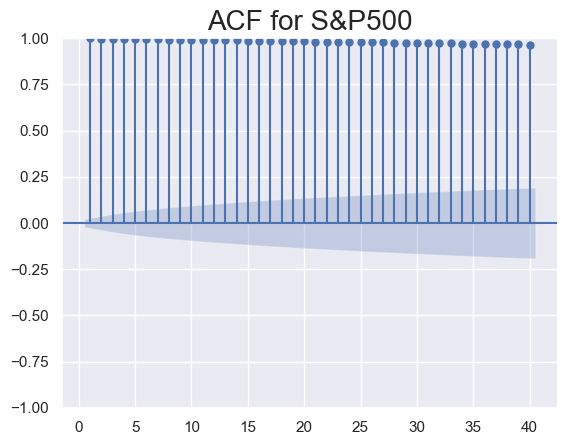

In [80]:
sgt.plot_acf(df_yfinance['spx'], zero = False, lags = 40)
plt.title("ACF for S&P500", size = 20)
plt.show()

### Modelo MA(1)

In [81]:
yfinance_model_ma_1 = ARIMA(df_yfinance['spx'], order=(0,0,1))

In [82]:
yfinance_results_ma_1 = yfinance_model_ma_1.fit()

In [83]:
yfinance_results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -62328.834
Date:                Wed, 18 Sep 2024   AIC                         124663.668
Time:                        17:54:00   BIC                         124684.627
Sample:                    01-07-1994   HQIC                        124670.843
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.9199     20.734     87.725      0.000    1778.282    1859.558
ma.L1          0.9886      0.001    848.098      0.000       0.986       0.991
sigma2      3.478e+05   7271.591     47.834      0.000    3.34e+05    3.62e+05
===================================================================================
Ljung-Box (L1) (Q):                7626.21   Jarque-Bera (JB):              2548.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.50   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos MA más complejos

In [84]:
yfinance_model_ma_10 = ARIMA(df_yfinance['spx'], order=(0,0,10))

In [85]:
yfinance_results_ma_10 = yfinance_model_ma_10.fit()

In [86]:
yfinance_results_ma_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                ARIMA(0, 0, 10)   Log Likelihood              -63326.754
Date:                Wed, 18 Sep 2024   AIC                         126677.508
Time:                        17:54:28   BIC                         126761.343
Sample:                    01-07-1994   HQIC                        126706.205
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8033    873.089      2.083      0.037     107.581    3530.025
ma.L1          1.0615      0.464      2.287      0.022       0.152       1.971
ma.L2          1.4387      0.318      4.522      0.000       0.815       2.062
ma.L3          1.7929      0.455      3.939      0.000       0.901       2.685
ma.L4          1.6620      0.650      2.556      0.011       0.388       2.936
ma.L5          1.4566      0.661      2.203      0.028       0.161       2.752
ma.L6          0.5989      0.647      0.926      0.355      -0.669       1.867
ma.L7          0.4293      0.708      0.606      0.544      -0.959       1.817
ma.L8          0.0656      0.479      0.137      0.891      -0.872       1.004
ma.L9         -0.3607      0.346     -1.043      0.297      -1.039       0.317
ma.L10        -0.3854      0.480     -0.802      0.422      -1.327       0.556
sigma2      1.169e+06   3.11e+04     37.570      0.000    1.11e+06    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                1452.37   Jarque-Bera (JB):             16384.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.39   Skew:                             1.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.26e+14. Standard errors may be unstable.
"""

### Pruebas LLR

In [87]:
LLR_test(yfinance_model_ma_1, yfinance_model_ma_10,DF=9)

1.0

## Vuelos

### ACF

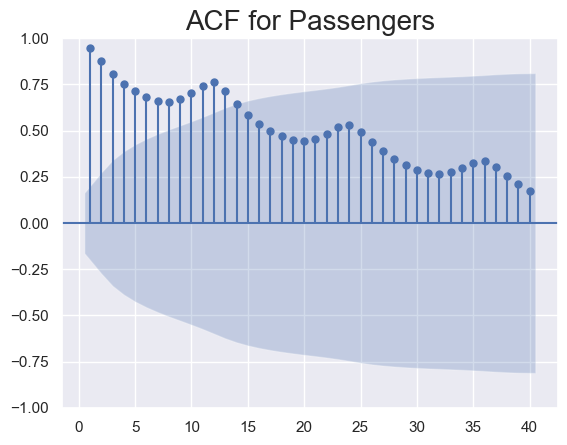

In [88]:
sgt.plot_acf(df_airline['Passengers'], zero = False, lags = 40)
plt.title("ACF for Passengers", size = 20)
plt.show()

### Modelo MA(1)

In [89]:
airline_model_ma_1 = ARIMA(df_airline['Passengers'], order=(0,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [90]:
airline_results_ma_1 = airline_model_ma_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [91]:
airline_results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -806.431
Date:                Wed, 18 Sep 2024   AIC                           1618.863
Time:                        17:55:04   BIC                           1627.772
Sample:                    01-01-1949   HQIC                          1622.483
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.6497     11.649     24.092      0.000     257.818     303.481
ma.L1          0.9642      0.030     32.218      0.000       0.906       1.023
sigma2      4205.2319    586.726      7.167      0.000    3055.270    5355.194
===================================================================================
Ljung-Box (L1) (Q):                  88.26   Jarque-Bera (JB):                 9.03
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.63   Skew:                             0.60
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos MA de mayor complejidad

In [92]:
airline_model_ma_14 = ARIMA(df_airline['Passengers'], order=(0,0,14))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [93]:
airline_results_ma_14 = airline_model_ma_14.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
airline_results_ma_14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(0, 0, 14)   Log Likelihood                -690.493
Date:                Wed, 18 Sep 2024   AIC                           1412.986
Time:                        17:55:08   BIC                           1460.503
Sample:                    01-01-1949   HQIC                          1432.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3025     30.078      9.319      0.000     221.350     339.255
ma.L1          1.3046   1061.082      0.001      0.999   -2078.378    2080.987
ma.L2          1.0493   1238.300      0.001      0.999   -2425.975    2428.073
ma.L3          0.8424   1710.995      0.000      1.000   -3352.646    3354.331
ma.L4          0.7420   1263.275      0.001      1.000   -2475.231    2476.715
ma.L5          0.7093   1219.732      0.001      1.000   -2389.921    2391.340
ma.L6          0.5679    394.665      0.001      0.999    -772.961     774.097
ma.L7          0.9908     20.649      0.048      0.962     -39.480      41.461
ma.L8          0.5347    448.751      0.001      0.999    -879.000     880.070
ma.L9          0.7471   1283.184      0.001      1.000   -2514.246    2515.741
ma.L10         0.7846   1247.827      0.001      0.999   -2444.912    2446.481
ma.L11         0.8343   1693.286      0.000      1.000   -3317.945    3319.614
ma.L12         1.0736   1200.046      0.001      0.999   -2350.973    2353.120
ma.L13         1.2599    993.699      0.001      0.999   -1946.354    1948.874
ma.L14         0.9366      0.190      4.922      0.000       0.564       1.310
sigma2       654.5081     47.031     13.917      0.000     562.329     746.687
===================================================================================
Ljung-Box (L1) (Q):                   5.88   Jarque-Bera (JB):                97.48
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               6.22   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.28e+20. Standard errors may be unstable.
"""

### Pruebas LLR

In [95]:
LLR_test(airline_model_ma_1, airline_model_ma_14,DF=13)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.6607164585869914e-42

## Ventas

### ACF

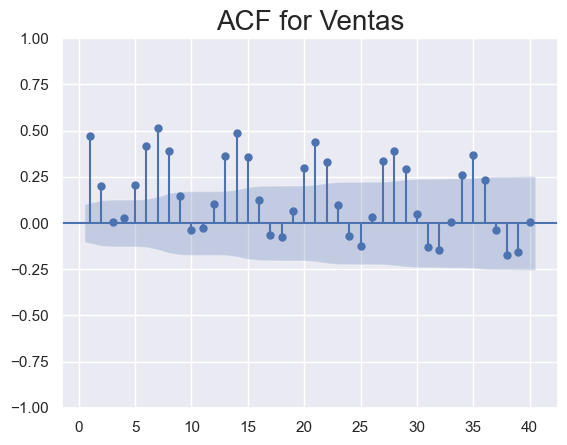

In [96]:
sgt.plot_acf(df_ventas['Ventas'], zero = False, lags = 40)
plt.title("ACF for Ventas", size = 20)
plt.show()

### Modelo MA(1)

In [97]:
ventas_model_ma_1 = ARIMA(df_ventas['Ventas'], order=(0,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [98]:
ventas_results_ma_1 = ventas_model_ma_1.fit()

In [99]:
ventas_results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3410.235
Date:                Wed, 18 Sep 2024   AIC                           6826.470
Time:                        17:55:12   BIC                           6838.169
Sample:                    01-01-2023   HQIC                          6831.119
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    206.839     91.043      0.000    1.84e+04    1.92e+04
ma.L1          0.3969      0.049      8.112      0.000       0.301       0.493
sigma2       7.65e+06   5.44e+05     14.059      0.000    6.58e+06    8.72e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.02   Jarque-Bera (JB):                 7.05
Prob(Q):                              0.08   Prob(JB):                         0.03
Heteroskedasticity (H):               0.87   Skew:                            -0.31
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos MA de mayor complejidad

In [100]:
ventas_model_ma_7 = ARIMA(df_ventas['Ventas'], order=(0,0,7))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [101]:
ventas_results_ma_7 = ventas_model_ma_7.fit()

In [102]:
ventas_results_ma_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -3383.598
Date:                Wed, 18 Sep 2024   AIC                           6785.197
Time:                        17:55:13   BIC                           6820.296
Sample:                    01-01-2023   HQIC                          6799.145
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    337.588     55.782      0.000    1.82e+04    1.95e+04
ma.L1          0.3365      0.060      5.602      0.000       0.219       0.454
ma.L2          0.1060      0.066      1.597      0.110      -0.024       0.236
ma.L3         -0.0460      0.065     -0.705      0.481      -0.174       0.082
ma.L4         -0.0028      0.060     -0.046      0.963      -0.120       0.115
ma.L5          0.1591      0.066      2.409      0.016       0.030       0.289
ma.L6          0.2743      0.070      3.940      0.000       0.138       0.411
ma.L7          0.2532      0.055      4.635      0.000       0.146       0.360
sigma2      7.828e+06   7.09e+05     11.034      0.000    6.44e+06    9.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.43   Prob(JB):                         0.25
Heteroskedasticity (H):               0.92   Skew:                            -0.21
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas LLR

In [103]:
LLR_test(ventas_model_ma_1, ventas_model_ma_7,DF=6)

1.033718468645517e-09

## Datos macroeconómicos de EEUU: PBI real

### ACF

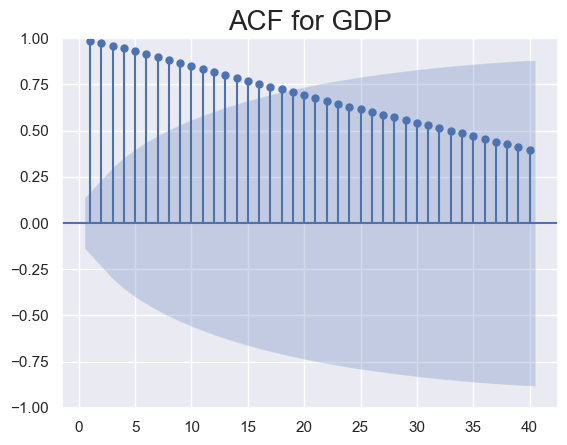

In [104]:
sgt.plot_acf(df_macrodata['realgdp'], zero = False, lags = 40)
plt.title("ACF for GDP", size = 20)
plt.show()

### Modelo MA(1)

In [105]:
realgdp_model_ma_1 = ARIMA(df_macrodata['realgdp'], order=(0,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [106]:
realgdp_results_ma_1 = realgdp_model_ma_1.fit()

In [107]:
realgdp_results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  203
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1790.681
Date:                Wed, 18 Sep 2024   AIC                           3587.361
Time:                        17:55:14   BIC                           3597.301
Sample:                    03-31-1959   HQIC                          3591.382
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7222.1316    247.357     29.197      0.000    6737.321    7706.943
ma.L1          1.0000      0.150      6.645      0.000       0.705       1.295
sigma2       2.63e+06   2.31e-05   1.14e+11      0.000    2.63e+06    2.63e+06
===================================================================================
Ljung-Box (L1) (Q):                 192.55   Jarque-Bera (JB):                13.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.43
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.19e+29. Standard errors may be unstable.
"""

### Modelos MA de mayor complejidad

In [108]:
realgdp_model_ma_19 = ARIMA(df_macrodata['realgdp'], order=(0,0,19))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [109]:
realgdp_results_ma_19 = realgdp_model_ma_19.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [110]:
realgdp_results_ma_19.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  203
Model:                ARIMA(0, 0, 19)   Log Likelihood               -1208.056
Date:                Wed, 18 Sep 2024   AIC                           2458.113
Time:                        17:55:23   BIC                           2527.690
Sample:                    03-31-1959   HQIC                          2486.261
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7221.3320    493.497     14.633      0.000    6254.095    8188.569
ma.L1          1.6298    166.942      0.010      0.992    -325.571     328.831
ma.L2          2.5580     46.479      0.055      0.956     -88.539      93.655
ma.L3          3.5639     45.666      0.078      0.938     -85.941      93.069
ma.L4          4.6320      3.254      1.424      0.155      -1.745      11.009
ma.L5          5.4986    181.830      0.030      0.976    -350.881     361.879
ma.L6          6.1969     67.641      0.092      0.927    -126.378     138.771
ma.L7          6.8640     11.423      0.601      0.548     -15.525      29.253
ma.L8          7.1294     19.016      0.375      0.708     -30.140      44.399
ma.L9          7.1527    119.155      0.060      0.952    -226.387     240.693
ma.L10         7.1710     98.153      0.073      0.942    -185.206     199.548
ma.L11         6.9878      4.106      1.702      0.089      -1.061      15.036
ma.L12         6.4128     63.432      0.101      0.919    -117.913     130.738
ma.L13         5.5018     56.999      0.097      0.923    -106.214     117.217
ma.L14         4.6431    149.343      0.031      0.975    -288.063     297.349
ma.L15         3.6512      4.440      0.822      0.411      -5.051      12.354
ma.L16         2.5228     90.463      0.028      0.978    -174.782     179.828
ma.L17         1.6980     39.540      0.043      0.966     -75.799      79.195
ma.L18         0.8528     95.331      0.009      0.993    -185.992     187.698
ma.L19         0.5710      0.124      4.597      0.000       0.328       0.814
sigma2      7571.7783      0.051   1.49e+05      0.000    7571.679    7571.878
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                12.06
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+23. Standard errors may be unstable.
"""

### Pruebas LLR

In [111]:
LLR_test(realgdp_model_ma_1, realgdp_model_ma_19,DF=18)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.112351650913575e-236

## Datos macroeconómicos de EEUU: Inflación

### ACF

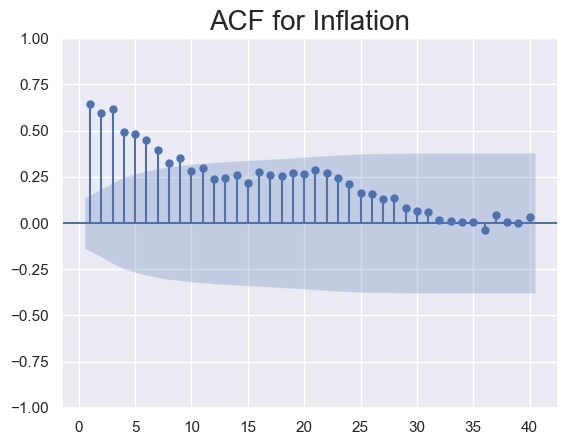

In [112]:
sgt.plot_acf(df_macrodata['infl'], zero = False, lags = 40)
plt.title("ACF for Inflation", size = 20)
plt.show()

### Modelo MA(1)

In [113]:
inflation_model_ma_1 = ARIMA(df_macrodata['infl'], order=(0,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [114]:
inflation_results_ma_1 = inflation_model_ma_1.fit()

In [115]:
inflation_results_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   infl   No. Observations:                  203
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -493.998
Date:                Wed, 18 Sep 2024   AIC                            993.997
Time:                        17:55:31   BIC                           1003.936
Sample:                    03-31-1959   HQIC                           998.018
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9542      0.296     13.346      0.000       3.374       4.535
ma.L1          0.4995      0.040     12.418      0.000       0.421       0.578
sigma2         7.5965      0.534     14.220      0.000       6.549       8.644
===================================================================================
Ljung-Box (L1) (Q):                   3.78   Jarque-Bera (JB):                44.98
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.37
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos MA de mayor complejidad

In [116]:
inflation_model_ma_10 = ARIMA(df_macrodata['infl'], order=(0,0,10))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [117]:
inflation_results_ma_10 = inflation_model_ma_10.fit()

In [118]:
inflation_results_ma_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   infl   No. Observations:                  203
Model:                ARIMA(0, 0, 10)   Log Likelihood                -450.871
Date:                Wed, 18 Sep 2024   AIC                            925.741
Time:                        17:55:32   BIC                            965.500
Sample:                    03-31-1959   HQIC                           941.826
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9013      0.634      6.153      0.000       2.659       5.144
ma.L1          0.4035      0.045      8.935      0.000       0.315       0.492
ma.L2          0.2712      0.075      3.594      0.000       0.123       0.419
ma.L3          0.4736      0.064      7.444      0.000       0.349       0.598
ma.L4          0.2449      0.075      3.254      0.001       0.097       0.392
ma.L5          0.2937      0.111      2.641      0.008       0.076       0.512
ma.L6          0.3446      0.082      4.208      0.000       0.184       0.505
ma.L7          0.2219      0.095      2.341      0.019       0.036       0.408
ma.L8          0.0292      0.101      0.289      0.773      -0.169       0.227
ma.L9          0.2412      0.109      2.221      0.026       0.028       0.454
ma.L10         0.0729      0.092      0.794      0.427      -0.107       0.253
sigma2         4.9371      0.320     15.426      0.000       4.310       5.564
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               162.26
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -0.54
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas LLR

In [119]:
LLR_test(inflation_model_ma_1, inflation_model_ma_10,DF=9)

9.155314651192564e-15

# Modelos ARMA

## Yahoo finance

### Modelo ARMA(1,1)

In [120]:
yfinance_model_ar_1_ma_1 = ARIMA(df_yfinance['spx'], order=(1,0,1))

In [121]:
yfinance_results_ar_1_ma_1 = yfinance_model_ar_1_ma_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [122]:
yfinance_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -36430.283
Date:                Wed, 18 Sep 2024   AIC                          72868.566
Time:                        17:55:42   BIC                          72896.511
Sample:                    01-07-1994   HQIC                         72878.131
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8521   6.07e-05      3e+07      0.000    1818.852    1818.852
ar.L1          1.0000   7.79e-05   1.28e+04      0.000       1.000       1.000
ma.L1         -0.0749      0.004    -18.606      0.000      -0.083      -0.067
sigma2       532.5699      2.777    191.778      0.000     527.127     538.013
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):            106334.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               8.60   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.61e+20. Standard errors may be unstable.
"""

### Modelos ARMA de mayor complejidad

In [123]:
yfinance_model_ar_1_ma_10 = ARIMA(df_yfinance['spx'], order=(1,0,10))

In [124]:
yfinance_results_ar_1_ma_10 = yfinance_model_ar_1_ma_10.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [125]:
yfinance_results_ar_1_ma_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 7992
Model:                ARIMA(1, 0, 10)   Log Likelihood              -36351.318
Date:                Wed, 18 Sep 2024   AIC                          72728.636
Time:                        17:56:36   BIC                          72819.456
Sample:                    01-07-1994   HQIC                         72759.724
                         - 08-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1818.8105   3.45e-05   5.27e+07      0.000    1818.810    1818.811
ar.L1          1.0000   7.72e-05   1.29e+04      0.000       1.000       1.000
ma.L1         -0.0623      0.005    -13.317      0.000      -0.071      -0.053
ma.L2          0.0168      0.004      3.784      0.000       0.008       0.026
ma.L3         -0.0193      0.005     -4.290      0.000      -0.028      -0.010
ma.L4          0.0003      0.005      0.062      0.950      -0.010       0.010
ma.L5         -0.0046      0.005     -0.960      0.337      -0.014       0.005
ma.L6         -0.0479      0.005    -10.004      0.000      -0.057      -0.039
ma.L7          0.0498      0.005      9.773      0.000       0.040       0.060
ma.L8         -0.0414      0.005     -8.425      0.000      -0.051      -0.032
ma.L9          0.1007      0.005     19.630      0.000       0.091       0.111
ma.L10        -0.0548      0.005    -10.673      0.000      -0.065      -0.045
sigma2       522.1624      3.224    161.947      0.000     515.843     528.482
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             81055.96
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               8.17   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.79e+20. Standard errors may be unstable.
"""

### Pruebas LLR

In [126]:
print("\nARMA vs AR ", LLR_test(yfinance_model_ar_1, yfinance_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(yfinance_model_ma_1, yfinance_model_ar_1_ma_1))
print("\nARMA vs ARMA(1,10) ", LLR_test(yfinance_model_ar_1_ma_1, yfinance_model_ar_1_ma_10,DF=9))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs AR  3.035488024490658e-12


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs MA  0.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs ARMA(1,10)  1.9987439360996618e-29


## Vuelos

### Modelo ARMA(1,1)

In [127]:
airline_model_ar_1_ma_1 = ARIMA(df_airline['Passengers'], order=(1,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [128]:
airline_results_ar_1_ma_1 = airline_model_ar_1_ma_1.fit()

In [129]:
airline_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -700.874
Date:                Wed, 18 Sep 2024   AIC                           1409.749
Time:                        17:58:21   BIC                           1421.628
Sample:                    01-01-1949   HQIC                          1414.576
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3009     56.644      4.948      0.000     169.281     391.321
ar.L1          0.9373      0.028     34.009      0.000       0.883       0.991
ma.L1          0.4264      0.076      5.642      0.000       0.278       0.574
sigma2       968.4365    112.711      8.592      0.000     747.527    1189.346
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.89
Prob(Q):                              0.84   Prob(JB):                         0.39
Heteroskedasticity (H):               6.81   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos ARMA de mayor complejidad

In [130]:
airline_model_ar_2_ma_14 = ARIMA(df_airline['Passengers'], order=(2,0,14))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [131]:
airline_results_ar_2_ma_14=airline_model_ar_2_ma_14.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [132]:
airline_results_ar_2_ma_14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                ARIMA(2, 0, 14)   Log Likelihood                -639.192
Date:                Wed, 18 Sep 2024   AIC                           1314.384
Time:                        17:58:24   BIC                           1367.841
Sample:                    01-01-1949   HQIC                          1336.106
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        280.3019   2388.853      0.117      0.907   -4401.764    4962.368
ar.L1          0.1277      0.191      0.668      0.504      -0.247       0.502
ar.L2          0.8703      0.188      4.635      0.000       0.502       1.238
ma.L1          1.0317    145.308      0.007      0.994    -283.766     285.830
ma.L2          0.0140    232.579   6.02e-05      1.000    -455.832     455.860
ma.L3         -0.2208     98.978     -0.002      0.998    -194.213     193.772
ma.L4         -0.3226    135.177     -0.002      0.998    -265.264     264.619
ma.L5         -0.2962     97.266     -0.003      0.998    -190.933     190.341
ma.L6         -0.1556     53.742     -0.003      0.998    -105.487     105.176
ma.L7         -0.0830     49.870     -0.002      0.999     -97.827      97.661
ma.L8         -0.2737     52.794     -0.005      0.996    -103.749     103.202
ma.L9         -0.3246    135.959     -0.002      0.998    -266.800     266.150
ma.L10        -0.2346     82.480     -0.003      0.998    -161.892     161.423
ma.L11        -0.2702    201.446     -0.001      0.999    -395.098     394.557
ma.L12         0.6886    199.405      0.003      0.997    -390.138     391.515
ma.L13         1.1910     46.412      0.026      0.980     -89.775      92.157
ma.L14         0.3189      0.191      1.668      0.095      -0.056       0.694
sigma2       338.3252      2.745    123.274      0.000     332.946     343.704
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.42
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               6.64   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+21. Standard errors may be unstable.
"""

### Pruebas LLR

In [133]:
print("\nARMA vs AR ", LLR_test(airline_model_ar_1, airline_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(airline_model_ma_1, airline_model_ar_1_ma_1))
print("\nARMA vs ARMA(2,14) ", LLR_test(airline_model_ar_1_ma_1, airline_model_ar_2_ma_14,DF=13))


ARMA vs AR  6.1794137348884034e-06


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARMA vs MA  7.8499746710177e-48


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARMA vs ARMA(2,14)  4.3469021857930366e-20


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Ventas

### Modelo ARMA (1,1)

In [134]:
ventas_model_ar_1_ma_1 = ARIMA(df_ventas['Ventas'], order=(1,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [135]:
ventas_results_ar_1_ma_1 = ventas_model_ar_1_ma_1.fit()

In [136]:
ventas_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3400.992
Date:                Wed, 18 Sep 2024   AIC                           6809.984
Time:                        17:58:28   BIC                           6825.583
Sample:                    01-01-2023   HQIC                          6816.183
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    269.040     69.995      0.000    1.83e+04    1.94e+04
ar.L1          0.4446      0.104      4.259      0.000       0.240       0.649
ma.L1          0.0436      0.120      0.362      0.717      -0.192       0.279
sigma2      7.254e+06   5.19e+05     13.964      0.000    6.24e+06    8.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.34
Prob(Q):                              0.98   Prob(JB):                         0.04
Heteroskedasticity (H):               0.95   Skew:                            -0.30
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos ARMA de mayor complejidad

In [137]:
ventas_model_ar_1_ma_7 = ARIMA(df_ventas['Ventas'], order=(1,0,7))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [138]:
ventas_results_ar_1_ma_7 = ventas_model_ar_1_ma_7.fit()

In [139]:
ventas_results_ar_1_ma_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(1, 0, 7)   Log Likelihood               -3374.416
Date:                Wed, 18 Sep 2024   AIC                           6768.831
Time:                        17:58:29   BIC                           6807.830
Sample:                    01-01-2023   HQIC                          6784.330
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    412.390     45.664      0.000     1.8e+04    1.96e+04
ar.L1          0.8355      0.065     12.930      0.000       0.709       0.962
ma.L1         -0.4519      0.087     -5.180      0.000      -0.623      -0.281
ma.L2         -0.1416      0.059     -2.408      0.016      -0.257      -0.026
ma.L3         -0.1753      0.061     -2.875      0.004      -0.295      -0.056
ma.L4         -0.0313      0.053     -0.594      0.553      -0.135       0.072
ma.L5          0.0779      0.063      1.237      0.216      -0.045       0.201
ma.L6          0.1331      0.065      2.058      0.040       0.006       0.260
ma.L7          0.1082      0.066      1.641      0.101      -0.021       0.237
sigma2      6.292e+06   4.57e+05     13.756      0.000     5.4e+06    7.19e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 4.24
Prob(Q):                              0.86   Prob(JB):                         0.12
Heteroskedasticity (H):               0.97   Skew:                            -0.22
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.36e+14. Standard errors may be unstable.
"""

### Pruebas LLR

In [140]:
print("\nARMA vs AR ", LLR_test(ventas_model_ar_1, ventas_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(ventas_model_ma_1, ventas_model_ar_1_ma_1))
print("\nARMA vs ARMA(1,7) ", LLR_test(ventas_model_ar_1_ma_1, ventas_model_ar_1_ma_7,DF=8))


ARMA vs AR  0.6243078781746039

ARMA vs MA  1.7117539232796553e-05

ARMA vs ARMA(1,7)  1.0076089386041563e-08


## Datos macroeconómicos de EEUU: PBI real

### Modelo ARMA(1,1)

In [141]:
realgdp_model_ar_1_ma_1 = ARIMA(df_macrodata['realgdp'], order=(1,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [142]:
realgdp_results_ar_1_ma_1 = realgdp_model_ar_1_ma_1.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [143]:
realgdp_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  203
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1148.197
Date:                Wed, 18 Sep 2024   AIC                           2304.394
Time:                        17:58:31   BIC                           2317.647
Sample:                    03-31-1959   HQIC                          2309.755
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7221.1945   1.03e+04      0.698      0.485    -1.3e+04    2.75e+04
ar.L1          0.9998      0.002    471.725      0.000       0.996       1.004
ma.L1          0.4169      0.061      6.811      0.000       0.297       0.537
sigma2      4586.3388    449.972     10.193      0.000    3704.410    5468.268
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):                19.03
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos ARMA de mayor complejidad

In [144]:
realgdp_model_ar_1_ma_19 = ARIMA(df_macrodata['realgdp'], order=(1,0,19))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [145]:
realgdp_results_ar_1_ma_19 = realgdp_model_ar_1_ma_19.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [146]:
realgdp_results_ar_1_ma_19.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  203
Model:                ARIMA(1, 0, 19)   Log Likelihood               -1105.437
Date:                Wed, 18 Sep 2024   AIC                           2254.875
Time:                        17:58:38   BIC                           2327.765
Sample:                    03-31-1959   HQIC                          2284.363
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7221.1723   6714.386      1.075      0.282   -5938.782    2.04e+04
ar.L1          0.9980      0.011     88.905      0.000       0.976       1.020
ma.L1          0.4852      0.793      0.612      0.540      -1.068       2.039
ma.L2          0.4720      0.179      2.633      0.008       0.121       0.823
ma.L3          0.2015      0.194      1.038      0.299      -0.179       0.582
ma.L4          0.3438      0.676      0.509      0.611      -0.981       1.668
ma.L5          0.1777      0.573      0.310      0.757      -0.946       1.302
ma.L6          0.3244      0.628      0.517      0.605      -0.906       1.554
ma.L7          0.1898      0.205      0.928      0.353      -0.211       0.591
ma.L8          0.0536      0.212      0.253      0.800      -0.362       0.469
ma.L9          0.2866      0.436      0.657      0.511      -0.569       1.142
ma.L10         0.3519      0.341      1.033      0.302      -0.316       1.020
ma.L11         0.3497      0.632      0.553      0.580      -0.890       1.589
ma.L12         0.0233      0.190      0.123      0.902      -0.350       0.396
ma.L13         0.1403      0.251      0.560      0.576      -0.351       0.631
ma.L14         0.1246      0.454      0.274      0.784      -0.765       1.015
ma.L15        -0.1373      0.392     -0.350      0.726      -0.906       0.632
ma.L16         0.1808      0.212      0.855      0.393      -0.234       0.596
ma.L17         0.1831      0.249      0.735      0.463      -0.305       0.671
ma.L18         0.0413      0.187      0.221      0.825      -0.325       0.407
ma.L19         0.1140      0.207      0.550      0.582      -0.292       0.520
sigma2      4436.5712   4250.823      1.044      0.297   -3894.888    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.64   Prob(JB):                         0.85
Heteroskedasticity (H):               2.12   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Pruebas LLR

In [147]:
print("\nARMA vs AR ", LLR_test(realgdp_model_ar_1, realgdp_model_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(realgdp_model_ma_1, realgdp_model_ar_1_ma_1))
print("\nARMA vs ARMA(1,19) ", LLR_test(realgdp_model_ar_1_ma_1, realgdp_model_ar_1_ma_19,DF=18))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs AR  1.009098381428772e-14


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs MA  2.0894561306201366e-281


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



ARMA vs ARMA(1,19)  9.115909176206802e-11


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Datos macroeconómicos de EEUU: Inflación

## Modelo ARMA(1,1)

In [148]:
inflation_model_ar_1_ma_1 = ARIMA(df_macrodata['infl'], order=(1,0,1))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [149]:
inflation_results_ar_1_ma_1 = inflation_model_ar_1_ma_1.fit()

In [150]:
inflation_results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   infl   No. Observations:                  203
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -456.076
Date:                Wed, 18 Sep 2024   AIC                            920.151
Time:                        17:58:45   BIC                            933.404
Sample:                    03-31-1959   HQIC                           925.513
                         - 09-30-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6931      1.121      3.294      0.001       1.496       5.891
ar.L1          0.9340      0.030     31.178      0.000       0.875       0.993
ma.L1         -0.5754      0.055    -10.555      0.000      -0.682      -0.469
sigma2         5.2119      0.316     16.513      0.000       4.593       5.831
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               178.46
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -0.82
Prob(H) (two-sided):                  0.03   Kurtosis:                         7.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelos ARMA de mayor complejidad

In [151]:
ventas_results_ma_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Ventas   No. Observations:                  365
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -3383.598
Date:                Wed, 18 Sep 2024   AIC                           6785.197
Time:                        17:58:45   BIC                           6820.296
Sample:                    01-01-2023   HQIC                          6799.145
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.883e+04    337.588     55.782      0.000    1.82e+04    1.95e+04
ma.L1          0.3365      0.060      5.602      0.000       0.219       0.454
ma.L2          0.1060      0.066      1.597      0.110      -0.024       0.236
ma.L3         -0.0460      0.065     -0.705      0.481      -0.174       0.082
ma.L4         -0.0028      0.060     -0.046      0.963      -0.120       0.115
ma.L5          0.1591      0.066      2.409      0.016       0.030       0.289
ma.L6          0.2743      0.070      3.940      0.000       0.138       0.411
ma.L7          0.2532      0.055      4.635      0.000       0.146       0.360
sigma2      7.828e+06   7.09e+05     11.034      0.000    6.44e+06    9.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 2.77
Prob(Q):                              0.43   Prob(JB):                         0.25
Heteroskedasticity (H):               0.92   Skew:                            -0.21
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
inflation_results_ar_3_ma_10 = inflation_model_ar_3_ma_10.fit()

NameError: name 'inflation_model_ar_3_ma_10' is not defined

In [ ]:
inflation_results_ar_3_ma_10.summary()